# Clusterización de información de productos en función de características

## Importación de librerias necesarias

In [1]:
%load_ext IPython.extensions.autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

def find_src_folder(current_path: Path, folder_name: str = 'src') -> Path:
    search_directories = [current_path] + list(current_path.parents)
    for parent in search_directories:
        if parent.name == folder_name:
            return parent.parent
    return current_path

src_path = find_src_folder(Path.cwd(), 'src')
sys.path.append(str(src_path))

In [3]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

import pandas as pd

from matplotlib.ticker import FuncFormatter

import tensorflow_hub as hub

from sklearn.neighbors import NearestNeighbors

from langchain_ollama.embeddings import OllamaEmbeddings

from sklearn.cluster import DBSCAN

from src.utils import SparkUtils

2025-06-15 22:07:55.179110: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 22:07:55.342647: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 22:07:55.487910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750043275.595708  100033 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750043275.630538  100033 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 22:07:55.939438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [4]:
spark_utils = SparkUtils()

your 131072x1 screen size is bogus. expect trouble
25/06/15 22:09:04 WARN Utils: Your hostname, ASUSPRIMEA520MAII resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/06/15 22:09:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/mnt/c/Users/User/Documents/Maestr%c3%ada/Amazon%20Reviews%20Code/.venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/edgar/.ivy2/cache
The jars for the packages stored in: /home/edgar/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-082e604b-dc38-4709-b6f6-3e76eec32304;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.3.1 in central
	found io.delta#delta-storage;3.3.1 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 231ms :: artifacts dl 7ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.3.1 from central in [default]
	io.delta#delta-storage;3.3.1 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0   

## Cargar modelo embedding (Llama3)

In [5]:
model = OllamaEmbeddings( model = 'llama3' )

## Generar agrupación basada en título de primera cuantificación de item 

#### Cargar información de títulos

In [6]:
meta_items_pandas_sample = spark_utils.get_meta_items_sample( 100 )

In [7]:
sentences = meta_items_pandas_sample['title'].to_list()

In [8]:
embeddings = model.embed_documents( sentences )

In [9]:
embeddings_np = np.array( embeddings )
embeddings_np.shape

(100, 4096)

#### Agglomerative Clustering

In [10]:
N_AGGLOMERATIVE_CLUSTERS = 5

In [11]:
agg_model = AgglomerativeClustering(n_clusters=N_AGGLOMERATIVE_CLUSTERS, linkage='ward')
labels = agg_model.fit_predict(embeddings_np)

meta_items_pandas_sample['agg_cluster'] = labels

**Examinar agrupaciones resultado**

Examinar ejemplos de cada una de las agrupaciones generadas

In [12]:
for i in range( N_AGGLOMERATIVE_CLUSTERS ):
    print(f">>>> Cluster {i + 1}")
    display( meta_items_pandas_sample[ meta_items_pandas_sample['agg_cluster'] == i ][['title', 'agg_cluster']].head(10) )
    print(f">>>>\n")

>>>> Cluster 1


,title,agg_cluster
1,Ankylosaurus Fights Back - Smithsonian's Prehi...,0
4,Traffic Police: Off-Road Cub,0
5,Shadow Fighting Superhero War,0
6,My Aquarium - Hidden Object Challenge # 122,0
7,Giant Surprise Petcage! Unlock Superhero Puppy,0
8,Ac Market tips,0
12,RoverCraft Race Your Space Car,0
13,HALLOWEEN MATCH 3 IN A ROW,0
21,"New Coupons, Daily Deals and Freebies - Update...",0
24,Soccer by Fawesome.tv,0


>>>>

>>>> Cluster 2


,title,agg_cluster
0,Accupressure Guide,1
2,Mahjong 2015,1
9,Gem Shopping Network,1
14,For Rent: Haunted House,1
15,Fat Dragons,1
17,Line Rider,1
18,World Explorer,1
22,Hide and Seek,1
23,London Transport Status,1
27,Schwab Advisor Center® Mobile,1


>>>>

>>>> Cluster 3


,title,agg_cluster
10,Piano Wizard Premier With 49E Keystation,2
19,Corel PaintShop Pro X4 [Old Version],2
20,Que Publishing 0789738252 Power Excel 2007 wit...,2
45,Microsoft Virtual PC for Mac 6.1 [Old Version],2
47,AutoCAD Freestyle [Old Version],2
48,Anime Studio Pro 9.5,2
54,Kaspersky Internet Security Multi-Device 2015 ...,2
60,MyScript Studio Notes Edition [Download],2
69,Family Historian 5 Deluxe Genealogy Software,2
73,Tell Me More v10 Spanish - 2 Levels,2


>>>>

>>>> Cluster 4


,title,agg_cluster
3,Jewels Brick Breakout,3
11,Boxing Game 3D - Real Fighting,3
16,TrainMania Lite,3
25,Last Survivor - Zombie Attack - Free Survival ...,3
39,MMA Circuit Timer Pro,3
52,Oil Tycoon - Idle Clicker Game,3
57,Police Car Driver 2016,3
61,Full HD Borescope app PRO,3
66,Secret Message Pro,3
67,2048 Drop n Merge Numbers: Match 3 Columns Puzzle,3


>>>>

>>>> Cluster 5


,title,agg_cluster
35,Audio recorder mp3,4
49,html editor writer cpdmc,4
79,role playing chat,4
96,Lock Screen OS9 - Phone 6s,4


>>>>



#### DBScan Clustering

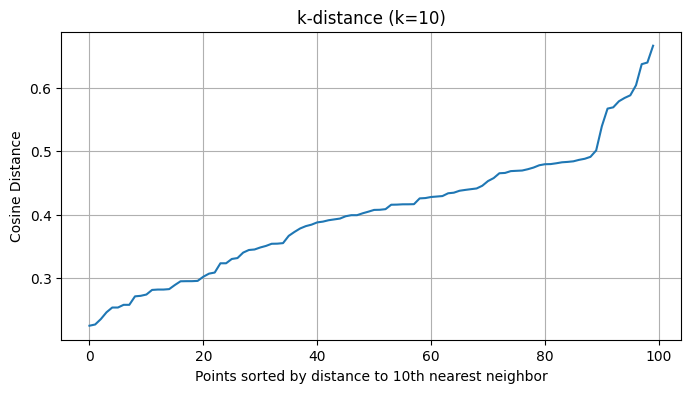

In [24]:
X = embeddings_np

neighbors = NearestNeighbors(n_neighbors=5, metric='cosine')
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

k_distances = np.sort(distances[:, 4])

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title("k-distance (k=10)")
plt.xlabel("Points sorted by distance to 10th nearest neighbor")
plt.ylabel("Cosine Distance")
plt.grid(True)
plt.show()

In [25]:
dbscan_model = DBSCAN(
    eps = 0.4,
    metric = 'cosine',
    min_samples = 5
)

In [26]:
meta_items_pandas_sample['dbscan_cluster'] = dbscan_model.fit_predict( embeddings_np )

In [27]:
dbscan_labels = set(dbscan_model.labels_)

In [28]:
for i in dbscan_labels:
    print(f">>>> Cluster {i + 1}")
    display( meta_items_pandas_sample[ meta_items_pandas_sample['dbscan_cluster'] == i ][['title', 'dbscan_cluster']].head(10) )
    print(f">>>>\n")

>>>> Cluster 1


,title,dbscan_cluster
0,Accupressure Guide,0
1,Ankylosaurus Fights Back - Smithsonian's Prehi...,0
2,Mahjong 2015,0
3,Jewels Brick Breakout,0
5,Shadow Fighting Superhero War,0
6,My Aquarium - Hidden Object Challenge # 122,0
9,Gem Shopping Network,0
11,Boxing Game 3D - Real Fighting,0
12,RoverCraft Race Your Space Car,0
15,Fat Dragons,0


>>>>

>>>> Cluster 0


,title,dbscan_cluster
4,Traffic Police: Off-Road Cub,-1
7,Giant Surprise Petcage! Unlock Superhero Puppy,-1
8,Ac Market tips,-1
10,Piano Wizard Premier With 49E Keystation,-1
13,HALLOWEEN MATCH 3 IN A ROW,-1
14,For Rent: Haunted House,-1
21,"New Coupons, Daily Deals and Freebies - Update...",-1
23,London Transport Status,-1
27,Schwab Advisor Center® Mobile,-1
28,How to Start a Boarding School Plus Business Plan,-1


>>>>

